In [8]:
%load_ext autoreload

%autoreload 2

In [1]:
import os
import logging

logger = logging.getLogger(__name__)

os.chdir("../")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.etl import *
from src.rfm import *
from src.utils import *

In [3]:
url = "https://www.gutenberg.org/cache/epub/1533/pg1533-images.html"

make_dataset(url)

Dataset already downloaded: download_log -> 6157ee4b54ae1a9c39fa52c057f5dfbd80554c634644ba4fc805528bf36a68f7


False

In [4]:
X, vocab = tokenizer("./data/Author: William Shakespeare.txt")

In [5]:
X.shape

(853, 32, 64)

In [6]:
data = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

In [7]:
data.shape

(853, 2048)

In [9]:
vocab

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 'A': 27,
 'B': 28,
 'C': 29,
 'D': 30,
 'E': 31,
 'F': 32,
 'G': 33,
 'H': 34,
 'I': 35,
 'J': 36,
 'K': 37,
 'L': 38,
 'M': 39,
 'N': 40,
 'O': 41,
 'P': 42,
 'Q': 43,
 'R': 44,
 'S': 45,
 'T': 46,
 'U': 47,
 'V': 48,
 'W': 49,
 'X': 50,
 'Y': 51,
 'Z': 52,
 '.': 53,
 ',': 54,
 '!': 55,
 '?': 56,
 "'": 57,
 ':': 58,
 ';': 59,
 '-': 60,
 '_': 61,
 ' ': 0,
 '[PAD]': 62,
 '[UNK]': 63}

## Baseline: Bigrams/Trigrams

In [128]:
from nltk.util import bigrams, trigrams, pad_sequence
from nltk.lm.preprocessing import padded_everygram_pipeline, flatten
from nltk.lm import MLE

In [87]:
CONTEXT_SIZE = 32
TEST_SPLIT = 0.2

In [175]:
def clean_sentence(sent):
    # remove newline and separate into characters
    sent = list(sent[:-1])
    # add start token and truncate to context size
    sent = (["<START>"] + sent)[:CONTEXT_SIZE]
    # pad to context size
    if len(sent) == CONTEXT_SIZE:
        return sent
    elif len(sent) < CONTEXT_SIZE:
        # add end token
        sent = sent + ["<END>"]
        return sent + ["<PAD>"] * (CONTEXT_SIZE - len(sent))
    else:
        raise ValueError("Sentence too long after truncating. Something went wrong.")


In [176]:
# get the text

fpath = "./data/Author: William Shakespeare.txt"
raw = open(fpath, "r").readlines()
sentences = list(map(clean_sentence, raw))
train_sentences = sentences[:int(len(sentences) * (1 - TEST_SPLIT))]
test_sentences = sentences[int(len(sentences) * (1 - TEST_SPLIT)):]
len(train_sentences)

682

In [177]:
np.array(train_sentences)[:, :16].shape

(682, 16)

In [178]:
# shop the dataset in half. The first half will be used to condition the second half
CONTEXT_SPLIT_SIZE = 16
X_train = np.array(train_sentences)[:, :16]
y_train = np.array(train_sentences)[:, 16:]
X_test = np.array(test_sentences)[:, :16]
y_test = np.array(test_sentences)[:, 16:]

In [179]:
# get ngrams
ngrams = []
for sent in X_train:
    ngrams.append(list(bigrams(sent)))

ngrams

[[('<START>', 'T'),
  ('T', 'i'),
  ('i', 't'),
  ('t', 'l'),
  ('l', 'e'),
  ('e', ':'),
  (':', ' '),
  (' ', 'M'),
  ('M', 'a'),
  ('a', 'c'),
  ('c', 'b'),
  ('b', 'e'),
  ('e', 't'),
  ('t', 'h'),
  ('h', '<END>')],
 [('<START>', 'A'),
  ('A', 'u'),
  ('u', 't'),
  ('t', 'h'),
  ('h', 'o'),
  ('o', 'r'),
  ('r', ':'),
  (':', ' '),
  (' ', 'W'),
  ('W', 'i'),
  ('i', 'l'),
  ('l', 'l'),
  ('l', 'i'),
  ('i', 'a'),
  ('a', 'm')],
 [('<START>', 'R'),
  ('R', 'e'),
  ('e', 'l'),
  ('l', 'e'),
  ('e', 'a'),
  ('a', 's'),
  ('s', 'e'),
  ('e', ' '),
  (' ', 'D'),
  ('D', 'a'),
  ('a', 't'),
  ('t', 'e'),
  ('e', ':'),
  (':', ' '),
  (' ', 'N')],
 [('<START>', 'L'),
  ('L', 'a'),
  ('a', 'n'),
  ('n', 'g'),
  ('g', 'u'),
  ('u', 'a'),
  ('a', 'g'),
  ('g', 'e'),
  ('e', ':'),
  (':', ' '),
  (' ', 'E'),
  ('E', 'n'),
  ('n', 'g'),
  ('g', 'l'),
  ('l', 'i')],
 [('<START>', 'A'),
  ('A', 'C'),
  ('C', 'T'),
  ('T', ' '),
  (' ', 'I'),
  ('I', 'S'),
  ('S', 'c'),
  ('c', 'e'),
  ('e', 'n

In [180]:
# pad the text
vocab = list(flatten(sent for sent in X_train))

In [181]:
lm = MLE(3)
lm.fit(ngrams, vocab)

In [183]:
X_train[1]

array(['<START>', 'A', 'u', 't', 'h', 'o', 'r', ':', ' ', 'W', 'i', 'l',
       'l', 'i', 'a', 'm'], dtype='<U7')

In [184]:
def generate_text(lm, X_test, length=16):
    # generate text
    text = []
    for sent in X_test:
        text.append(lm.generate(length, text_seed=sent))
    return text

In [185]:
y_test.shape

(171, 16)

In [186]:
y_test_pred = np.array(generate_text(lm, X_test))

In [187]:
"".join(y_test[0]), "".join(y_test_pred[0])

(' the whetstone o', ' g wit d STH.Y a')

In [219]:
lm.vocab.unk_label

'<UNK>'

In [274]:
class Vocab():
    def __init__(self, vals):
        self._dict = {v: i for i, v in enumerate(vals)}
        self._dict['<UNK>'] = len(self._dict)
        self.rev = {i: v for v, i in self._dict.items()}
    
    def __getitem__(self, key):
        if key in self._dict:
            return self._dict[key]
        else:
            return self._dict['<UNK>']
    
    def __len__(self):
        return len(self._dict)
    
    def __iter__(self):
        return iter(self._dict)
    
    def __contains__(self, key):
        return key in self._dict
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self._dict})"
    
    def decode(self, idx):
        return self.rev[idx]

In [275]:
train_vocab = Vocab(list(sorted(lm.vocab.counts.keys())))
train_vocab

Vocab({' ': 0, '!': 1, ',': 2, '-': 3, '.': 4, ':': 5, ';': 6, '<END>': 7, '<PAD>': 8, '<START>': 9, '?': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, '[': 35, ']': 36, 'a': 37, 'b': 38, 'c': 39, 'd': 40, 'e': 41, 'f': 42, 'g': 43, 'h': 44, 'i': 45, 'j': 46, 'k': 47, 'l': 48, 'm': 49, 'n': 50, 'o': 51, 'p': 52, 'q': 53, 'r': 54, 's': 55, 't': 56, 'u': 57, 'v': 58, 'w': 59, 'x': 60, 'y': 61, '—': 62, '’': 63, '“': 64, '<UNK>': 65})

In [227]:
def encode(sent, vocab=train_vocab):
    return np.array([vocab[w] for w in sent])

def evaluate(y_test, y_test_pred):
    # evaluate
    bleu = []
    perplexity = []
    y_perplexity = []
    for i in range(len(y_test)):
        bleu.append(utils.bleu_score([y_test[i]], y_test_pred[i], n=1))
        perplexity.append(utils.perplexity(encode(y_test_pred[i])))
        y_perplexity.append(utils.perplexity(encode(y_test[i])))
    return { "bleu1": np.mean(bleu), "perplexity": np.mean(perplexity), "true_perplexity": np.mean(y_perplexity) }

In [236]:
evaluate(y_test, y_test_pred)

/home/arunavgupta/Documents/UCSD/ml-theory-capstone/src/utils.py:198: RuntimeWarning: divide by zero encountered in log2


{'bleu1': 0.40460526315789475,
 'perplexity': 12.759944954161845,
 'true_perplexity': 12.526818139778857}

## Laplacian Kernel

In [251]:
# replace each token with its index in the vocab
X_train_enc = np.array([encode(sent) for sent in X_train])
y_train_enc = np.array([encode(sent) for sent in y_train])
X_test_enc = np.array([encode(sent) for sent in X_test])
y_test_enc = np.array([encode(sent) for sent in y_test])

In [252]:
# one hot encode the data
X_train_enc = np.eye(len(train_vocab))[X_train_enc]
X_train_enc = X_train_enc.reshape(X_train_enc.shape[0], X_train_enc.shape[1]*X_train_enc.shape[2])
y_train_enc = np.eye(len(train_vocab))[y_train_enc]
y_train_enc = y_train_enc.reshape(y_train_enc.shape[0], y_train_enc.shape[1]*y_train_enc.shape[2])
X_test_enc = np.eye(len(train_vocab))[X_test_enc]
X_test_enc = X_test_enc.reshape(X_test_enc.shape[0], X_test_enc.shape[1]*X_test_enc.shape[2])
y_test_enc = np.eye(len(train_vocab))[y_test_enc]
y_test_enc = y_test_enc.reshape(y_test_enc.shape[0], y_test_enc.shape[1]*y_test_enc.shape[2])

In [253]:
from functools import partial

In [260]:
next_char_train = y_train_enc[:, :len(train_vocab)]
next_char_test = y_test_enc[:, :len(train_vocab)]

In [262]:
# train a laplace kernel
lam = 0.1
kernel = partial(utils.K_laplace_mat, gamma=0.0128)

K = kernel(X_train_enc, X_train_enc)
alpha_hat = np.linalg.solve(K + lam * np.eye(K.shape[0]), next_char_train)

In [271]:
yhat = kernel(X_train_enc, X_train_enc) @ alpha_hat
yhat

array([[ 0.02390579,  0.        ,  0.02355603, ...,  0.01204692,
         0.        ,  0.        ],
       [ 0.70517953,  0.        ,  0.01017237, ...,  0.03244508,
         0.        ,  0.        ],
       [-0.01372742,  0.        ,  0.01382728, ..., -0.00190199,
         0.        ,  0.        ],
       ...,
       [ 0.14802111,  0.        ,  0.00193691, ...,  0.01695421,
         0.        ,  0.        ],
       [ 0.65227576,  0.        ,  0.04062324, ..., -0.00921618,
         0.        ,  0.        ],
       [ 0.82456843,  0.        , -0.01490203, ...,  0.02522402,
         0.        ,  0.        ]])

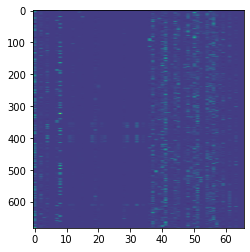

In [272]:
plt.imshow(yhat, aspect=0.1)

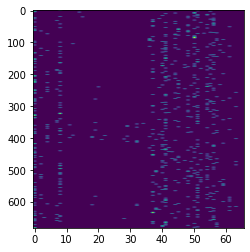

In [269]:
# plot next_char_train, with a good aspect ratio
plt.imshow(next_char_train, aspect=0.1)

In [287]:
next_char_train.argmax(axis=1) - yhat.argmax(axis=1)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  -4, -10,   0,
         0,   0,   0,   0, -11,  50,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  -3,   0,   0,  -3,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        -6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  14,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  14,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [283]:
def generate_text_kernel(kernel, alpha_hat, X, z, length=16):
    text = []
    for i in range(length):
        yhat = kernel(X, z) @ alpha_hat
        # decode the text
        text.append([train_vocab.decode(y) for y in np.argmax(yhat, axis=1)])
        # move the window forward
        X = np.concatenate([X[:, len(train_vocab):], yhat], axis=1)
    
    transpose = list(zip(*text))
    return transpose

In [289]:
generated_test = generate_text_kernel(kernel, alpha_hat, X_test_enc, X_train_enc, length=16)

In [290]:
evaluate(y_test, generated_test)

/home/arunavgupta/Documents/UCSD/ml-theory-capstone/src/utils.py:198: RuntimeWarning: divide by zero encountered in log2


{'bleu1': 0.44992690058479534,
 'perplexity': 9.22179291846029,
 'true_perplexity': 12.526818139778857}

## RFM

In [296]:
alpha, M = train_rfm(X_train_enc, next_char_train)

mp: (682, 682)


ValueError: too many values to unpack (expected 2)